In [217]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [218]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [219]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [220]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [221]:
tf.keras.backend.clear_session()

In [222]:
subject = 'Acre - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [223]:
data = pd.read_csv('2003_mo_model_input_AC.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Acre - Consumo de Cimento (t),Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,3.260000,10254.061200,0.773065,0.651726,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,6.587220e+06,0.643805,247158.775150,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,2.191000,10335.111969,0.773454,0.651847,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,6.590338e+06,0.644270,248180.775732,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,2.154000,10411.052710,0.773843,0.651968,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,6.593455e+06,0.644734,249202.776314,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,2.643000,10486.231639,0.774233,0.652088,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,6.596572e+06,0.645199,250224.776896,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,2.546000,10566.989914,0.774622,0.652209,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,6.599689e+06,0.645663,251246.777478,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
5,2003-6,3.040000,10631.423914,0.775011,0.652330,8.698514,0.692806,7.331577e+06,414402.197675,9.326282,6.602806e+06,0.646128,252268.778060,3.887612e+05,7.358314e+06,403.335811,1.998603e+06,0.912759,3.646791,0.909667,0.632759,-5720.383332,9.432415,127.126613,1.781144e+08,174.084035,1.707891
6,2003-7,4.963000,10694.321011,0.775400,0.652451,8.693636,0.693104,7.340751e+06,414600.786203,9.327854,6.605923e+06,0.646592,253290.778642,3.911512e+05,7.363915e+06,458.988732,2.015092e+06,0.910067,3.642520,0.890441,0.638014,-5884.375046,8.822930,127.277008,1.782958e+08,175.116868,1.598284
7,2003-8,2.924000,10753.133824,0.775789,0.652572,8.688757,0.693401,7.349925e+06,414799.374732,9.329427,6.609040e+06,0.647056,254312.779224,3.946027e+05,7.369516e+06,511.353665,2.025274e+06,0.889893,3.637478,0.870231,0.634634,-5959.855465,8.332470,127.785814,1.784773e+08,176.178119,1.721808
8,2003-9,5.276000,10810.976248,0.776178,0.652693,8.683879,0.693699,7.359099e+06,414997.963260,9.331000,6.612157e+06,0.647521,255334.779806,3.999086e+05,7.375117e+06,553.842751,2.031413e+06,0.866515,3.631689,0.844479,0.632327,-6014.809970,7.939984,128.294619,1.786588e+08,177.286906,1.635128
9,2003-10,5.262000,10868.405954,0.776568,0.652813,8.679001,0.693996,7.368272e+06,415196.551789,9.332573,6.615274e+06,0.647985,256356.780388,4.058071e+05,7.380718e+06,592.204755,2.157687e+06,0.849384,3.625181,0.842183,0.629038,-6121.266757,7.604976,128.803425,1.788403e+08,178.406445,1.811944


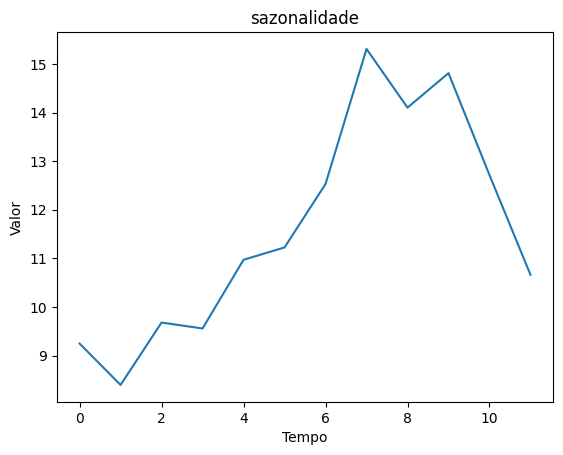

,sazonalidade
sazonalidade,
0,9.247150
1,8.395791
2,9.679136
3,9.557209
4,10.971298
5,11.224848
6,12.529942
7,15.309845
8,14.102365


In [224]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [225]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Acre - Consumo de Cimento (t)
0,2003-1,10254.061200,0.773065,0.651726,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,6.587220e+06,0.643805,247158.775150,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,9.247150,3.260000
1,2003-2,10335.111969,0.773454,0.651847,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,6.590338e+06,0.644270,248180.775732,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.395791,2.191000
2,2003-3,10411.052710,0.773843,0.651968,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,6.593455e+06,0.644734,249202.776314,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,9.679136,2.154000
3,2003-4,10486.231639,0.774233,0.652088,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,6.596572e+06,0.645199,250224.776896,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,9.557209,2.643000
4,2003-5,10566.989914,0.774622,0.652209,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,6.599689e+06,0.645663,251246.777478,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,10.971298,2.546000
5,2003-6,10631.423914,0.775011,0.652330,8.698514,0.692806,7.331577e+06,414402.197675,9.326282,6.602806e+06,0.646128,252268.778060,3.887612e+05,7.358314e+06,403.335811,1.998603e+06,0.912759,3.646791,0.909667,0.632759,-5720.383332,9.432415,127.126613,1.781144e+08,174.084035,1.707891,11.224848,3.040000
6,2003-7,10694.321011,0.775400,0.652451,8.693636,0.693104,7.340751e+06,414600.786203,9.327854,6.605923e+06,0.646592,253290.778642,3.911512e+05,7.363915e+06,458.988732,2.015092e+06,0.910067,3.642520,0.890441,0.638014,-5884.375046,8.822930,127.277008,1.782958e+08,175.116868,1.598284,12.529942,4.963000
7,2003-8,10753.133824,0.775789,0.652572,8.688757,0.693401,7.349925e+06,414799.374732,9.329427,6.609040e+06,0.647056,254312.779224,3.946027e+05,7.369516e+06,511.353665,2.025274e+06,0.889893,3.637478,0.870231,0.634634,-5959.855465,8.332470,127.785814,1.784773e+08,176.178119,1.721808,15.309845,2.924000
8,2003-9,10810.976248,0.776178,0.652693,8.683879,0.693699,7.359099e+06,414997.963260,9.331000,6.612157e+06,0.647521,255334.779806,3.999086e+05,7.375117e+06,553.842751,2.031413e+06,0.866515,3.631689,0.844479,0.632327,-6014.809970,7.939984,128.294619,1.786588e+08,177.286906,1.635128,14.102365,5.276000
9,2003-10,10868.405954,0.776568,0.652813,8.679001,0.693996,7.368272e+06,415196.551789,9.332573,6.615274e+06,0.647985,256356.780388,4.058071e+05,7.380718e+06,592.204755,2.157687e+06,0.849384,3.625181,0.842183,0.629038,-6121.266757,7.604976,128.803425,1.788403e+08,178.406445,1.811944,14.811785,5.262000


In [226]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0       4.105000
1       3.898000
2       4.209000
3       2.994000
4       3.720000
5       4.275000
6       4.699000
7       6.416000
8       6.427000
9       6.386000
10      5.591000
11      5.422000
12      5.807000
13      5.242000
14      4.965000
15      5.854000
16      5.892000
17      7.760000
18      7.484000
19      8.048000
20      7.794000
21      8.792000
22      6.725000
23      6.551000
24      7.192000
25      6.443000
26      9.429000
27      7.627000
28      9.283000
29      7.826000
30      7.907000
31     15.133000
32     12.318000
33     11.558000
34      9.965000
35      9.734000
36      6.647000
37      6.138000
38      9.225000
39      7.545000
40      9.279000
41      9.651000
42      9.541000
43     17.165000
44     15.001000
45     13.456000
46     10.572000
47      7.652000
48      8.457000
49      8.675000
50      6.078000
51      8.368000
52     11.648000
53     10.911000
54     12.003000
55     13.273000
56     11.838000
57     12.887000
58      7.6450

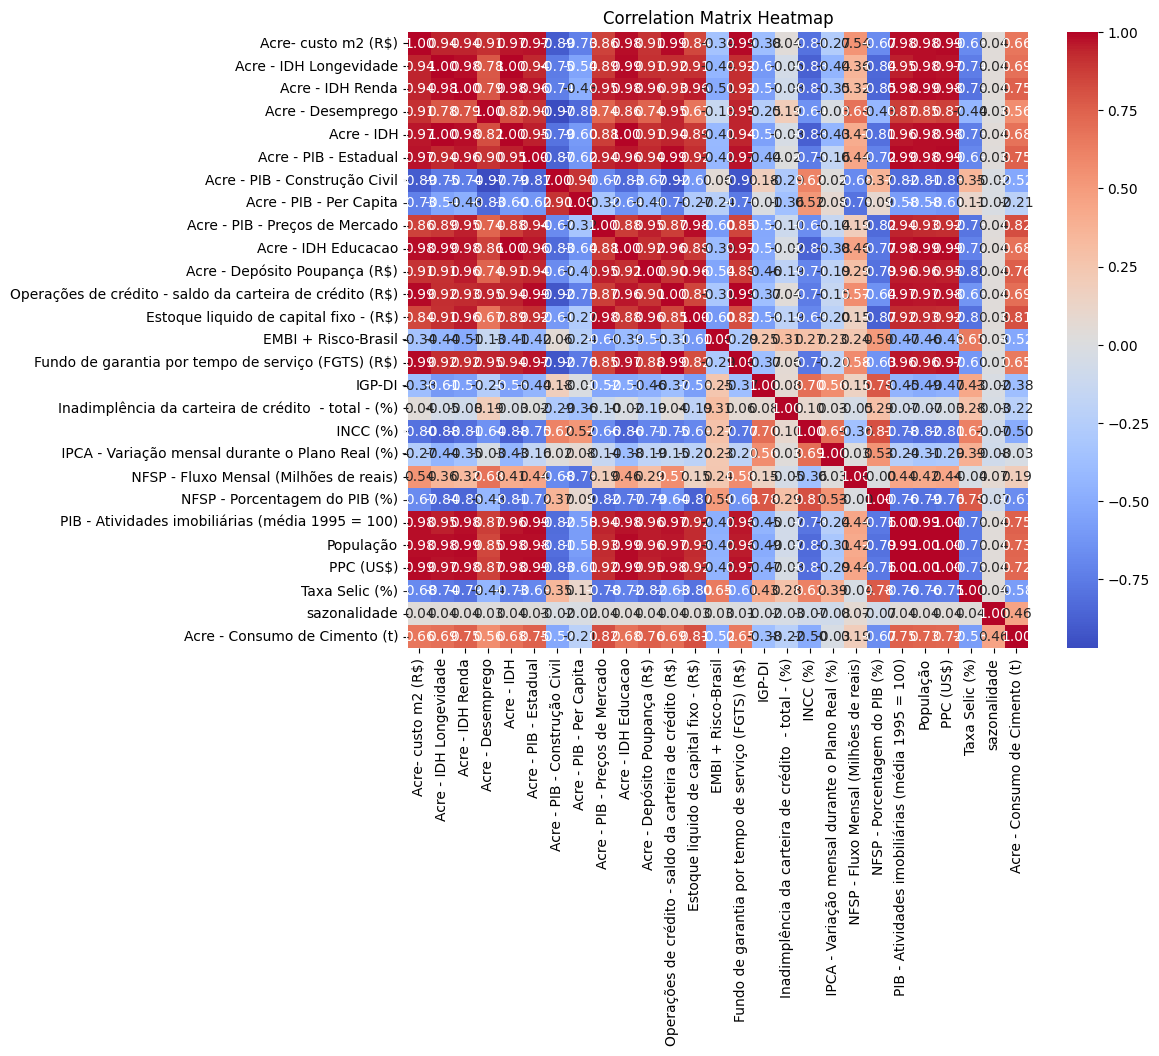

In [227]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [228]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [229]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Acre- custo m2 (R$),2.433668e+04
1,Acre - IDH Longevidade,2.573730e+08
2,Acre - IDH Renda,2.370532e+03
3,Acre - Desemprego,8.189869e+02
4,Acre - IDH,1.074568e+09
5,Acre - PIB - Estadual,9.724217e+04
6,Acre - PIB - Construção Civil,5.089299e+03
7,Acre - PIB - Per Capita,1.000720e+04
8,Acre - PIB - Preços de Mercado,3.487130e+04
9,Acre - IDH Educacao,1.276783e+08


In [230]:
# data =data.drop(['Acre- custo m2 (R$)',
#                  'Acre - IDH Longevidade',
#                  'Acre - IDH Renda', 
#                  'Acre - PIB - Estadual'], axis=1)
data = remove_high_vif_columns(safe_data, 100000)
data

Num columns removed: 9


,Acre- custo m2 (R$),Acre - Desemprego,Acre - PIB - Construção Civil,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,10254.061200,8.722906,413409.255032,247158.775150,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,9.247150
1,10335.111969,8.718028,413607.843560,248180.775732,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,8.395791
2,10411.052710,8.713149,413806.432089,249202.776314,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,9.679136
3,10486.231639,8.708271,414005.020618,250224.776896,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,9.557209
4,10566.989914,8.703393,414203.609146,251246.777478,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,10.971298
5,10631.423914,8.698514,414402.197675,252268.778060,3.887612e+05,403.335811,1.998603e+06,0.912759,3.646791,0.909667,0.632759,-5720.383332,9.432415,127.126613,174.084035,1.707891,11.224848
6,10694.321011,8.693636,414600.786203,253290.778642,3.911512e+05,458.988732,2.015092e+06,0.910067,3.642520,0.890441,0.638014,-5884.375046,8.822930,127.277008,175.116868,1.598284,12.529942
7,10753.133824,8.688757,414799.374732,254312.779224,3.946027e+05,511.353665,2.025274e+06,0.889893,3.637478,0.870231,0.634634,-5959.855465,8.332470,127.785814,176.178119,1.721808,15.309845
8,10810.976248,8.683879,414997.963260,255334.779806,3.999086e+05,553.842751,2.031413e+06,0.866515,3.631689,0.844479,0.632327,-6014.809970,7.939984,128.294619,177.286906,1.635128,14.102365
9,10868.405954,8.679001,415196.551789,256356.780388,4.058071e+05,592.204755,2.157687e+06,0.849384,3.625181,0.842183,0.629038,-6121.266757,7.604976,128.803425,178.406445,1.811944,14.811785


In [231]:
input_data = data
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Acre- custo m2 (R$),Acre - Desemprego,Acre - PIB - Construção Civil,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,0.000000,0.056128,0.693537,0.000000,0.000000,0.108706,0.015290,1.000000,0.790380,1.000000,1.000000,0.310283,1.000000,0.000000,0.000000,0.813935,0.123135
1,0.004292,0.054896,0.699191,0.002064,0.000205,0.058377,0.004961,0.936603,0.788742,0.968938,0.921240,0.311059,0.965719,0.001556,0.003548,0.698054,0.000000
2,0.008314,0.053663,0.704845,0.004128,0.000218,0.100305,0.000973,0.906543,0.788333,0.948438,0.873107,0.303979,0.927412,0.003112,0.007210,1.000000,0.185614
3,0.012295,0.052430,0.710499,0.006192,0.000375,0.211591,0.000000,0.858675,0.787696,0.928794,0.851659,0.287789,0.885588,0.004668,0.010957,0.629650,0.167979
4,0.016572,0.051197,0.716153,0.008257,0.000871,0.358835,0.002281,0.824839,0.784532,0.970421,0.823277,0.294233,0.838034,0.006586,0.014605,0.795263,0.372503
5,0.019984,0.049965,0.721807,0.010321,0.001432,0.487983,0.004755,0.817873,0.781231,0.901242,0.786908,0.286989,0.783307,0.008504,0.018469,0.883268,0.409175
6,0.023315,0.048732,0.727461,0.012385,0.002271,0.610828,0.006521,0.813911,0.777173,0.869588,0.799176,0.277178,0.720046,0.010422,0.022413,0.804430,0.597934
7,0.026429,0.047499,0.733114,0.014449,0.003482,0.726415,0.007611,0.784227,0.772381,0.836312,0.791287,0.272662,0.669139,0.016911,0.026466,0.893278,1.000000
8,0.029492,0.046266,0.738768,0.016513,0.005345,0.820203,0.008268,0.749828,0.766881,0.793912,0.785899,0.269374,0.628401,0.023400,0.030700,0.830931,0.825359
9,0.032534,0.045034,0.744422,0.018577,0.007416,0.904881,0.021788,0.724621,0.760697,0.790132,0.778221,0.263005,0.593630,0.029889,0.034975,0.958109,0.927964


In [232]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Acre- custo m2 (R$),Acre - Desemprego,Acre - PIB - Construção Civil,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,0.000000,0.056128,0.693537,0.000000,0.000000,0.108706,0.015290,1.000000,0.790380,1.000000,1.000000,0.310283,1.000000,0.000000,0.000000,0.813935,0.123135
1,0.004292,0.054896,0.699191,0.002064,0.000205,0.058377,0.004961,0.936603,0.788742,0.968938,0.921240,0.311059,0.965719,0.001556,0.003548,0.698054,0.000000
2,0.008314,0.053663,0.704845,0.004128,0.000218,0.100305,0.000973,0.906543,0.788333,0.948438,0.873107,0.303979,0.927412,0.003112,0.007210,1.000000,0.185614
3,0.012295,0.052430,0.710499,0.006192,0.000375,0.211591,0.000000,0.858675,0.787696,0.928794,0.851659,0.287789,0.885588,0.004668,0.010957,0.629650,0.167979
4,0.016572,0.051197,0.716153,0.008257,0.000871,0.358835,0.002281,0.824839,0.784532,0.970421,0.823277,0.294233,0.838034,0.006586,0.014605,0.795263,0.372503
5,0.019984,0.049965,0.721807,0.010321,0.001432,0.487983,0.004755,0.817873,0.781231,0.901242,0.786908,0.286989,0.783307,0.008504,0.018469,0.883268,0.409175
6,0.023315,0.048732,0.727461,0.012385,0.002271,0.610828,0.006521,0.813911,0.777173,0.869588,0.799176,0.277178,0.720046,0.010422,0.022413,0.804430,0.597934
7,0.026429,0.047499,0.733114,0.014449,0.003482,0.726415,0.007611,0.784227,0.772381,0.836312,0.791287,0.272662,0.669139,0.016911,0.026466,0.893278,1.000000
8,0.029492,0.046266,0.738768,0.016513,0.005345,0.820203,0.008268,0.749828,0.766881,0.793912,0.785899,0.269374,0.628401,0.023400,0.030700,0.830931,0.825359
9,0.032534,0.045034,0.744422,0.018577,0.007416,0.904881,0.021788,0.724621,0.760697,0.790132,0.778221,0.263005,0.593630,0.029889,0.034975,0.958109,0.927964


In [233]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       4.105000
1       3.898000
2       4.209000
3       2.994000
4       3.720000
5       4.275000
6       4.699000
7       6.416000
8       6.427000
9       6.386000
10      5.591000
11      5.422000
12      5.807000
13      5.242000
14      4.965000
15      5.854000
16      5.892000
17      7.760000
18      7.484000
19      8.048000
20      7.794000
21      8.792000
22      6.725000
23      6.551000
24      7.192000
25      6.443000
26      9.429000
27      7.627000
28      9.283000
29      7.826000
30      7.907000
31     15.133000
32     12.318000
33     11.558000
34      9.965000
35      9.734000
36      6.647000
37      6.138000
38      9.225000
39      7.545000
40      9.279000
41      9.651000
42      9.541000
43     17.165000
44     15.001000
45     13.456000
46     10.572000
47      7.652000
48      8.457000
49      8.675000
50      6.078000
51      8.368000
52     11.648000
53     10.911000
54     12.003000
55     13.273000
56     11.838000
57     12.887000
58      7.6450

In [234]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [235]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 17)

In [236]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Acre- custo m2 (R$),Acre - Desemprego,Acre - PIB - Construção Civil,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
126,0.629171,0.731313,0.374302,0.923530,0.758748,0.038989,0.611173,0.201912,0.381658,0.372054,0.612440,0.198892,0.052718,0.831584,0.769083,0.131587,0.597934
127,0.634883,0.742775,0.367222,0.936275,0.766876,0.054581,0.615820,0.209545,0.325565,0.375438,0.626227,0.212790,0.056653,0.834382,0.772016,0.217266,1.000000
128,0.640715,0.754236,0.360142,0.949020,0.775150,0.070743,0.616446,0.238038,0.273745,0.372254,0.645442,0.219584,0.060771,0.837180,0.774681,0.241706,0.825359
129,0.646701,0.765698,0.353061,0.961765,0.786449,0.084331,0.663874,0.249843,0.198953,0.369458,0.673151,0.215246,0.065105,0.839978,0.777064,0.080099,0.927964
130,0.652465,0.777159,0.345981,0.974510,0.798019,0.095511,0.722141,0.266770,0.131822,0.371547,0.699949,0.236663,0.069099,0.840204,0.779225,0.033180,0.624556
131,0.657916,0.788620,0.338901,0.987255,0.808124,0.105921,0.755352,0.272113,0.082533,0.362489,0.726228,0.360233,0.073328,0.840430,0.781151,0.113747,0.327857
132,0.663378,0.800082,0.331820,1.000000,0.815332,0.116855,0.735622,0.297841,0.063050,0.371805,0.749318,0.342590,0.076793,0.840657,0.786113,0.256061,0.123135
133,0.668816,0.810037,0.311033,0.984889,0.822873,0.128078,0.697780,0.310249,0.064498,0.359609,0.772822,0.389993,0.080065,0.842451,0.788852,0.279366,0.000000
134,0.674045,0.819991,0.290245,0.969778,0.830903,0.131464,0.686568,0.298259,0.087497,0.369384,0.767612,0.394586,0.083086,0.844245,0.791618,0.358796,0.185614
135,0.679316,0.829946,0.269458,0.954667,0.839096,0.133803,0.683057,0.264133,0.096187,0.378024,0.759444,0.390265,0.085709,0.846038,0.794336,0.210111,0.167979


In [237]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 17)

In [238]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [239]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=100, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=20)
#     train, train_val = validation_splitter(train_input, 6)
#     target,target_val = validation_splitter(train_target, 6)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(36, activation='tanh'),
        tf.keras.layers.Dense(18, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=200,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [240]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(5)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][20:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [241]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[113769311, 995753533, 792860437, 4062533146, 1981186905]


Step: 0 ___________________________________________
val_loss: 6.192678451538086
winner_seed: 113769311


Step: 1 ___________________________________________
val_loss: 6.192686080932617


Step: 2 ___________________________________________
val_loss: 6.192647933959961
winner_seed: 792860437


Step: 3 ___________________________________________
val_loss: 6.192656517028809


Step: 4 ___________________________________________
val_loss: 6.192688941955566


final_seed: 792860437


In [242]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/200
4/4 [==============================] - 2s 117ms/step - loss: 204.5658 - val_loss: 154.5338
Epoch 2/200
4/4 [==============================] - 0s 8ms/step - loss: 181.6918 - val_loss: 135.2930
Epoch 3/200
4/4 [==============================] - 0s 8ms/step - loss: 164.1115 - val_loss: 120.2119
Epoch 4/200
4/4 [==============================] - 0s 8ms/step - loss: 149.5761 - val_loss: 109.4837
Epoch 5/200
4/4 [==============================] - 0s 8ms/step - loss: 137.4555 - val_loss: 101.6604
Epoch 6/200
4/4 [==============================] - 0s 8ms/step - loss: 130.7248 - val_loss: 95.5973
Epoch 7/200
4/4 [==============================] - 0s 8ms/step - loss: 123.9880 - val_loss: 90.9037
Epoch 8/200
4/4 [==============================] - 0s 7ms/step - loss: 119.0451 - val_loss: 87.2151
Epoch 9/200
4/4 [==============================] - 0s 8ms/step - loss: 114.3825 - val_loss: 84.1899
Epoch 10/200
4/4 [==============================] - 0s 8ms/step - loss: 110.8324 - val_loss: 

Epoch 83/200
4/4 [==============================] - 0s 9ms/step - loss: 36.2686 - val_loss: 18.5982
Epoch 84/200
4/4 [==============================] - 0s 9ms/step - loss: 35.7977 - val_loss: 18.2545
Epoch 85/200
4/4 [==============================] - 0s 9ms/step - loss: 35.3834 - val_loss: 17.9099
Epoch 86/200
4/4 [==============================] - 0s 9ms/step - loss: 34.9638 - val_loss: 17.5716
Epoch 87/200
4/4 [==============================] - 0s 9ms/step - loss: 34.5750 - val_loss: 17.2386
Epoch 88/200
4/4 [==============================] - 0s 8ms/step - loss: 34.1497 - val_loss: 16.9222
Epoch 89/200
4/4 [==============================] - 0s 8ms/step - loss: 33.7616 - val_loss: 16.6155
Epoch 90/200
4/4 [==============================] - 0s 8ms/step - loss: 33.3675 - val_loss: 16.3147
Epoch 91/200
4/4 [==============================] - 0s 8ms/step - loss: 33.0195 - val_loss: 16.0110
Epoch 92/200
4/4 [==============================] - 0s 8ms/step - loss: 32.6311 - val_loss: 15.7189


4/4 [==============================] - 0s 8ms/step - loss: 19.3459 - val_loss: 6.5505
Epoch 165/200
4/4 [==============================] - 0s 8ms/step - loss: 19.2796 - val_loss: 6.5248
Epoch 166/200
4/4 [==============================] - 0s 8ms/step - loss: 19.2122 - val_loss: 6.5002
Epoch 167/200
4/4 [==============================] - 0s 8ms/step - loss: 19.1534 - val_loss: 6.4761
Epoch 168/200
4/4 [==============================] - 0s 8ms/step - loss: 19.1055 - val_loss: 6.4517
Epoch 169/200
4/4 [==============================] - 0s 8ms/step - loss: 19.0329 - val_loss: 6.4311
Epoch 170/200
4/4 [==============================] - 0s 8ms/step - loss: 18.9819 - val_loss: 6.4112
Epoch 171/200
4/4 [==============================] - 0s 8ms/step - loss: 18.9336 - val_loss: 6.3913
Epoch 172/200
4/4 [==============================] - 0s 8ms/step - loss: 18.8857 - val_loss: 6.3729
Epoch 173/200
4/4 [==============================] - 0s 8ms/step - loss: 18.8337 - val_loss: 6.3566
Epoch 174/200


In [243]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [244]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,13.052335,13.052335,13.052335,13.052335,13.052335,13.052334,13.052335,13.052334,13.052334,13.052333,13.052334,13.052334,13.052335,13.052334,13.052335,13.052335,13.052335,13.052335,13.052335,13.052335,13.052335,13.052335,13.052335,13.052335,13.052335,13.052336,13.052335,13.052336,13.052337,13.052337
Target,13.552,15.826,14.869,14.734,12.754,11.925,13.114,8.92,9.724,9.737,10.136,14.403,12.871,15.749,14.269,15.367,14.595,9.811,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,0.499665,2.773665,1.816666,1.681665,0.298335,1.127334,0.061666,4.132334,3.328334,3.315332,2.916334,1.350666,0.181334,2.696666,1.216665,2.314665,1.542665,3.241335,1.864335,2.671335,4.972335,1.898335,0.544334,0.926334,1.443666,3.670664,2.200665,3.478664,2.153664,2.892337


In [245]:
display(mae)
display(mape)

2.1070664

0.17951527

In [246]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [247]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[156.62804]] - Target[149.694]| =  Error: [[6.9340363]]; MAPE:[[0.0463214]]
1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[156.62804]] - Target[148.09900000000002]| =  Error: [[8.529037]]; MAPE:[[0.05759011]]
1/1 [==============================] - 0s 14ms/step
Ano-5: |Prediction[[78.31402]] - Target[88.369]| =  Error: [[10.054985]]; MAPE:[[0.11378407]]


[array([[6.9340363]], dtype=float32),
 array([[8.529037]], dtype=float32),
 array([[10.054985]], dtype=float32)]

8.50602

0.0725652